Reference: 

Introduction to Random Forests - 
https://www.datascience.com/resources/notebooks/random-forest-intro

In [1]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

## 1.0  Data acqusition & cleaning

In [2]:
# Loading data and cleaning dataset
UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
/breast-cancer-wisconsin/wdbc.data'

In [3]:
# names as column name for the cleaned dataframe
names = ['id_number', 'diagnosis', 'radius_mean',
         'texture_mean', 'perimeter_mean', 'area_mean',
         'smoothness_mean', 'compactness_mean',
         'concavity_mean','concave_points_mean',
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se',
         'area_se', 'smoothness_se', 'compactness_se',
         'concavity_se', 'concave_points_se',
         'symmetry_se', 'fractal_dimension_se',
         'radius_worst', 'texture_worst',
         'perimeter_worst', 'area_worst',
         'smoothness_worst', 'compactness_worst',
         'concavity_worst', 'concave_points_worst',
         'symmetry_worst', 'fractal_dimension_worst']

# target classes, will be used in model fitting (later)
dx = ['Benign', 'Malignant']

In [4]:
# read data
breast_cancer = pd.read_csv(urlopen(UCI_data_URL), names=names)

In [5]:
# Setting 'id_number' as our index
breast_cancer.set_index(['id_number'], inplace = True)
# [diagnosis] column data Converted to binary to help later on with models and plots
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

In [6]:
# show dataframe
breast_cancer

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.300100,0.147100,0.2419,0.07871,1.0950,0.9053,8.5890,153.400,0.006399,0.049040,0.053730,0.015870,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.71190,0.26540,0.4601,0.11890
842517,1,20.570,17.77,132.90,1326.0,0.08474,0.07864,0.086900,0.070170,0.1812,0.05667,0.5435,0.7339,3.3980,74.080,0.005225,0.013080,0.018600,0.013400,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.24160,0.18600,0.2750,0.08902
84300903,1,19.690,21.25,130.00,1203.0,0.10960,0.15990,0.197400,0.127900,0.2069,0.05999,0.7456,0.7869,4.5850,94.030,0.006150,0.040060,0.038320,0.020580,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.45040,0.24300,0.3613,0.08758
84348301,1,11.420,20.38,77.58,386.1,0.14250,0.28390,0.241400,0.105200,0.2597,0.09744,0.4956,1.1560,3.4450,27.230,0.009110,0.074580,0.056610,0.018670,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.68690,0.25750,0.6638,0.17300
84358402,1,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.198000,0.104300,0.1809,0.05883,0.7572,0.7813,5.4380,94.440,0.011490,0.024610,0.056880,0.018850,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.40000,0.16250,0.2364,0.07678
843786,1,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,0.2087,0.07613,0.3345,0.8902,2.2170,27.190,0.007510,0.033450,0.036720,0.011370,0.02165,0.005082,15.470,23.75,103.40,741.6,0.17910,0.52490,0.53550,0.17410,0.3985,0.12440
844359,1,18.250,19.98,119.60,1040.0,0.09463,0.10900,0.112700,0.074000,0.1794,0.05742,0.4467,0.7732,3.1800,53.910,0.004314,0.013820,0.022540,0.010390,0.01369,0.002179,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.37840,0.19320,0.3063,0.08368
84458202,1,13.710,20.83,90.20,577.9,0.11890,0.16450,0.093660,0.059850,0.2196,0.07451,0.5835,1.3770,3.8560,50.960,0.008805,0.030290,0.024880,0.014480,0.01486,0.005412,17.060,28.14,110.60,897.0,0.16540,0.36820,0.26780,0.15560,0.3196,0.11510
844981,1,13.000,21.82,87.50,519.8,0.12730,0.19320,0.185900,0.093530,0.2350,0.07389,0.3063,1.0020,2.4060,24.320,0.005731,0.035020,0.035530,0.012260,0.02143,0.003749,15.490,30.73,106.20,739.3,0.17030,0.54010,0.53900,0.20600,0.4378,0.10720


In [7]:
# check if there is a whole column missing 
# [col] for loop selecting each column 
# isnull() checking whether is any missing values, output asboolean
# Counting cells with missing values:  sum(df.isnull().values.ravel())
# reference: https://stackoverflow.com/questions/28199524/best-way-to-count-the-number-of-rows-with-missing-values-in-a-pandas-dataframe

for col in breast_cancer:
    if ((breast_cancer[col].isnull().values.ravel().sum()) == 0):
        pass
    else:
        print(col)
        print((breast_cancer[col].isnull().values.ravel().sum()))
print('Sanity Check! \ No missing Values found!')

Sanity Check! \ No missing Values found!


In [8]:
# For later use in CART models
# save all feature column names
names_index = names[2:]

In [9]:
# show basic stats for dataframe
breast_cancer.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## 2.0  set Features and Target data, Model fitting

In [10]:
# select all non-target (disgnosis) results as feature data
# selecting optimal number of features 
#feature_space = breast_cancer.iloc[:, breast_cancer.columns != 'diagnosis']
feature_space = breast_cancer.iloc[:, 1:11]

# select all target (disgnosis) results as target data
feature_class = breast_cancer.iloc[:, breast_cancer.columns == 'diagnosis']

# train-test data split at 70-30 ratio, random
# X_train, X_test, y_train, y_test. X as features, y as target
training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.30,
                                                                    random_state = 42)

In [11]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel()
test_class_set = test_class_set.values.ravel()

In [12]:
# Set the random state for reproductibility, keep at same number
fit_rf = RandomForestClassifier(random_state=42)

#### 2.1  Hyperparameter tuneing (model setting search)

In [13]:
np.random.seed(42)
# start = time.time()
# set ranges of parameters can be selected as different combination of model settings 
param_dist = {'max_depth': [2, 3, 4,8,10,20],
              'bootstrap': [True, False],
              'max_features': ['sqrt', 'log2'],   
              "min_samples_leaf" : [2,4,8],
              'criterion': ['gini', 'entropy']}
"""
max_features : 
If int, then consider max_features features at each split.
#If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
If “sqrt”, then max_features=sqrt(n_features).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.

Other selection of parameters can be: max_leaf_nodes, min_impurity_decrease, 
"""

# conduct grid search for different models, same it as model named "cv_rf"
# GridSearchCV: Exhaustive search over specified parameter values for an estimator.
# fit_rf (default settings of RandomForestClassifier) are default settings (baseline model) that set to optimize
# cv as corss validation 
# n_jobs: Number of jobs to run in parallel, default as 1
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

cv_rf = GridSearchCV(fit_rf, cv = 5,
                     param_grid=param_dist,
                     n_jobs = 3)

# use model to fit in X_train and y_train data. y_train as output 
cv_rf.fit(training_set, class_set)

print('Best Parameters using grid search: \n',
      cv_rf.best_params_)

# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2}


In [14]:
# Set best parameters given by grid search
fit_rf.set_params(criterion = 'entropy',
                  max_features = 'sqrt',
                  min_samples_leaf = 2,
                  max_depth = 4)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

##### 2.2   change RandomForestClassifier mdoel settings

In [15]:
#  changed from last output:  min_impurity_decrease=0.0, min_impurity_split=None
# here changed to min_impurity_split=1e-07   (0.0000001)
# min_impurity_split: Threshold for early stopping in tree growth. 
#                   A node will split if its impurity is above the threshold, otherwise it is a leaf.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

#### 2.3  Model error rate calculation and n_estimators tuning

In [16]:
# use model with new settings
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [17]:
# OOB rate calculation
# Range of `n_estimators` values to explore.
fit_rf.set_params(oob_score=True)

min_estimators = 10
max_estimators = 100

error_rate = {}

for i in range(min_estimators, max_estimators + 1,10):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set, class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

In [18]:
oob_series = pd.Series(error_rate)

C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'OOB Error Rate Across various Forest sizes \n(From 10 to 100 trees)')

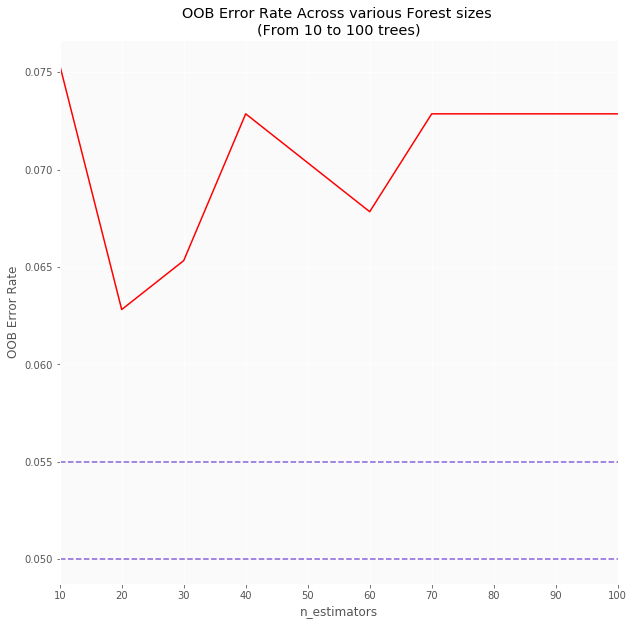

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_axis_bgcolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.055,
            color='#875FDB',
           linestyle='--')
plt.axhline(0.05,
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 10 to 100 trees)')

In [20]:
# n_estimators as number of trees in the forest
fit_rf.set_params(n_estimators=20)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

## 3.0 fitting test data into model

In [30]:
fit_rf.fit(training_set, class_set)
print('Accuracy of decision tree classifier on Train set: {:.3f}'.format(fit_rf.oob_score_))

Accuracy of decision tree classifier on Train set: 0.937


In [31]:
fit_rf.fit(test_set, test_class_set)
print('Accuracy of decision tree classifier on Test set: {:.3f}'.format(fit_rf.oob_score_))

Accuracy of decision tree classifier on Test set: 0.942


## 4.0 Bias Variance Tradeoff
Err(x) = Bias^2 + Variance + Irreducible Error

Reference: https://github.com/ParrotPrediction/docker-course-xgboost/blob/master/notebooks/3.%20Going%20deeper/3.2%20Bias-variance%20tradeoff.ipynb

http://education.parrotprediction.teachable.com/courses/78878/lectures/1137871

In [32]:
from sklearn.learning_curve import validation_curve

n_estimators_range = np.linspace(1, 270, 10).astype('int')

train_scores, test_scores = validation_curve(
    fit_rf,
    test_set, test_class_set,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=10,scoring='accuracy'
)

C:\Users\Claire\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Claire\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Users\Claire\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Claire\Anaconda3\lib\site-pack

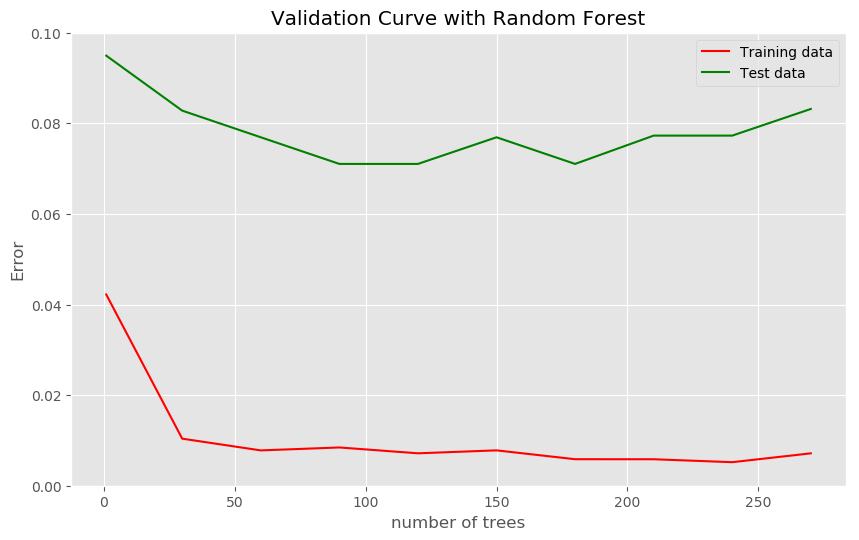

In [34]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with Random Forest")
plt.xlabel("number of trees")
plt.ylabel("Error")
plt.ylim(0.0, 0.1)

plt.plot(n_estimators_range,
             1-train_scores_mean,
             label="Training data",
             color="r")

plt.plot(n_estimators_range,
             1-test_scores_mean, 
             label="Test data",
             color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.savefig('Random_Forest.png')

plt.show()

i = np.argmax(test_scores_mean)